# Prompt

You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

Data description: Provide a high-level overview of your data and its timeframe along with general information on your dataset
Forecast: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
Uncertainty: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Sources

## Snow Report

Source:  
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customGroupByMonthReport/monthly/ABY:CA:SNOW%7Cid=%22%22%7Cname/POR_BEGIN,POR_END:1,2,3,4,5,6/WTEQ::collectionDate,SNWD::value,WTEQ::value

In [3]:
snow = pd.read_csv("./data/snow_report.csv")
snow

,Water Year,Jan,Jan.1,Jan.2,Feb,Feb.1,Feb.2,Mar,Mar.1,Mar.2,Apr,Apr.1,Apr.2,May,May.1,May.2,Jun,Jun.1,Jun.2
0,NaN,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values,Snow Water Equivalent Collection Date Start of...,Snow Depth (in) Start of Month Values,Snow Water Equivalent (in) Start of Month Values
1,1963.0,NaN,NaN,NaN,Feb 01,0,0.0,Feb 28,0,0.0,Apr 02,14,3.8,May 02,2,1.1,NaN,NaN,NaN
2,1964.0,Jan 03,8,2.4,Feb 04,33,9.8,Mar 03,35,10.6,Apr 02,31,9.6,Apr 28,0,0.0,NaN,NaN,NaN
3,1965.0,Jan 08,56,13.8,Feb 05,36,15.0,Mar 05,32,14.2,Apr 02,27,13.1,Apr 29,0,0.0,NaN,NaN,NaN
4,1966.0,Jan 13,37,10.6,Jan 28,35,10.2,Feb 24,40,12.1,Mar 30,16,6.8,May 05,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2020.0,Dec 28,12,3.0,Jan 28,12,4.0,Feb 25,9,3.0,Mar 27,20,5.5,Apr 24,0,0.0,NaN,NaN,NaN
59,2021.0,Dec 26,18,5.0,Jan 27,26,6.0,Feb 26,24,9.0,Mar 25,26,10.5,Apr 26,0,0.0,NaN,NaN,NaN
60,2022.0,Dec 26,48,10.0,Jan 31,26,9.5,Feb 26,26,10.0,Mar 31,0,0.0,Apr 24,0,0.0,NaN,NaN,NaN
61,2023.0,Dec 30,19,7.0,Jan 30,40,14.0,Feb 24,56,16.0,Mar 29,72,25.5,Apr 26,29,13.0,May 27,0,0.0


In [4]:
snow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Water Year  62 non-null     float64
 1   Jan         60 non-null     object 
 2   Jan.1       60 non-null     object 
 3   Jan.2       60 non-null     object 
 4   Feb         62 non-null     object 
 5   Feb.1       62 non-null     object 
 6   Feb.2       62 non-null     object 
 7   Mar         62 non-null     object 
 8   Mar.1       62 non-null     object 
 9   Mar.2       62 non-null     object 
 10  Apr         63 non-null     object 
 11  Apr.1       63 non-null     object 
 12  Apr.2       63 non-null     object 
 13  May         62 non-null     object 
 14  May.1       62 non-null     object 
 15  May.2       62 non-null     object 
 16  Jun         6 non-null      object 
 17  Jun.1       6 non-null      object 
 18  Jun.2       6 non-null      object 
dtypes: float64(1), object(18)
memor

<Axes: >

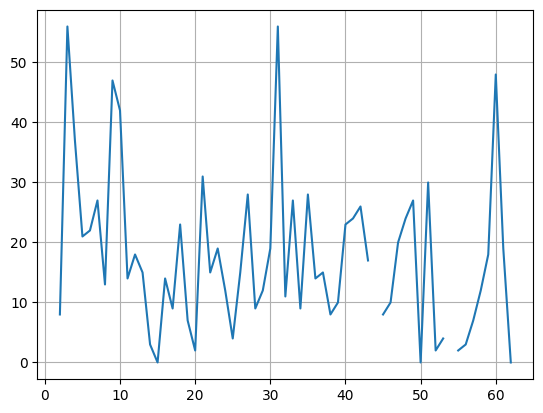

In [5]:
pd.to_numeric(snow["Jan.1"], errors="coerce").plot()

## Monthly Water Levels

Source:  
https://tidesandcurrents.noaa.gov/cgi-bin/reports.cgi?type=maxmin&bdate=19800408&datum=MSL&edate=20240407&units=standard&id=9419750&retrieve=&print=1

In [6]:
tides = pd.read_csv("./data/noaa_tides_and_currents_report.txt", delim_whitespace=True)
tides

,Year,Month,Zone,MaxDate,MaxTime,MaxWL,MinDate,MinTime,MinWL
0,1980,4,LST,19800415,00:00,4.10,19800417,00:00,-5.23
1,1980,5,LST,19800514,00:00,4.04,19800516,00:00,-5.85
2,1980,6,LST,19800611,00:00,4.06,19800613,00:00,-5.48
3,1980,7,LST,19800727,00:00,4.19,19800712,00:00,-5.25
4,1980,8,LST,19800808,00:00,3.96,19800826,00:00,-4.77
...,...,...,...,...,...,...,...,...,...
516,2023,11,LST,20231115,19:48,4.55,20231128,01:48,-4.99
517,2023,12,LST,20231227,19:00,5.10,20231215,03:00,-5.34
518,2024,1,LST,20240113,20:24,4.97,20240112,01:54,-6.00
519,2024,2,LST,20240207,16:30,4.68,20240210,01:36,-5.58


In [7]:
tides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     521 non-null    int64  
 1   Month    521 non-null    int64  
 2   Zone     521 non-null    object 
 3   MaxDate  521 non-null    int64  
 4   MaxTime  521 non-null    object 
 5   MaxWL    521 non-null    float64
 6   MinDate  521 non-null    int64  
 7   MinTime  521 non-null    object 
 8   MinWL    521 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 36.8+ KB


<Axes: >

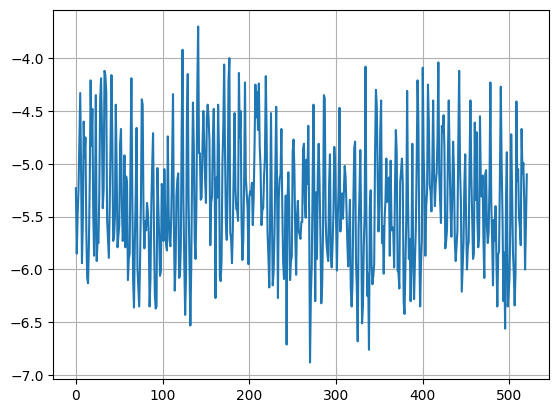

In [8]:
tides["MinWL"].plot()

<Axes: >

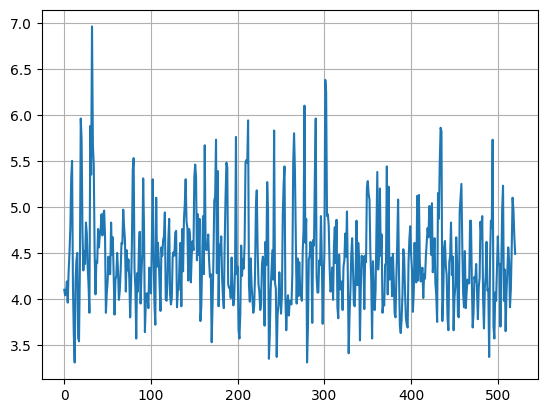

In [9]:
tides["MaxWL"].plot()

## Hourly Water Temperatures

Source:  
https://tidesandcurrents.noaa.gov/physocean.html?bdate=20231001&edate=20240407&units=standard&timezone=GMT&id=9419750&interval=h&action=data